# 1) Portrait Segmentation with original dataset 

I started by googling the phrase "Automatic Potrait Segmentation" and came across this paper  
["Automatic Portrait Segmentation for Image Stylization"](http://xiaoyongshen.me/webpage_portrait/papers/portrait_eg16.pdf)  
Xiaoyong Shen, Aaron Hertzmann, Jiaya Jia, Sylvain Paris, Brian Price, Eli Shechtman, Ian Sachs. Computer Graphics Forum, 35(2)(Proc. Eurographics), 2016


The authors had created a database using  potrait photographs uploaded on Flickr and manually created their segmentation masks for creating data for their task

One of the authors Xiaoyong Shen had the link to their project on his website
http://xiaoyongshen.me/webpage_portrait/index.html

The dataset wasn't readily available but scipts were provided in matlab(.m) format for downloading and preprocessing the images. Unfortunately I am not able to show the workings of those scripts in a jupyter environment but using the README provided I was able to run the scripts in Octave and  get the final dataset of images 

The dataset used in the paper from what I can infer used 1829 images along with their masks, however I could only get my hands on 1656 images. So my dataset is around 173 images short

The masks for the images were stored in .mat files so to get it in numpy format I needed to use scipy.io loadmat function

I also visited the celebrity face dataset aka CelebA and realised that there were no such segementation masks available for the images to be able to train. This meant that I had to use dataset from this paper to train my model and evaluate its performance on the CelebA images which acts as a test set  

The authors of the paper used a modified Fully Convolutional Network (FCN) along with potrait specific knowledge such as using a facial feature detectors for generating auxiliary position and shape channels. These are terms I do not understand. 
The also used a mean segmentation mask  (basically a mask were they expected a person to be present in an image) and normalized x,y coordinates of pixels as input to their model along with the images
They named their model (PortraitFCN+) 

I hope this image pulled from their paper explains the mean mask and normalized x,y 
![img](https://drive.google.com/uc?export=download&id=10WeIc6hYbViL-ABELGBwUBZfuoOtY2bq)


Compared to this my approach utilizes have almost zero preprocessing no additional masks and no use of any protrait specific knowledge.
PotraitFCN+ was able to achieve an Mean Intersection over Union (IoU) of 95.91%.  
My approch of using Dynamic U-Nets with lesser data and keeping the same train test splits was able to reach a mean IoU of 96.8%

The main reason for this notebook is to validate the use of U-Nets for the task of automatic potrait segmentation. This can be done by following the train,test splits and metrics used in the paper and comparing the results at the end.




I use the remainder of this notebook to describe my approach using the original dataset.   
The second notebook covers how I modify my model to use on the CelebA dataset 

I use the [fastai library](https://docs.fast.ai/) which has been built on top of PyTorch as my preferance of a deep learning framework

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from PIL import Image
import scipy.io as sio

In [3]:
path = Path('data/[EG_code_data]_release/data')

Using the python pathlib module

In [4]:
path.ls()

[PosixPath('data/[EG_code_data]_release/data/mask_png'),
 PosixPath('data/[EG_code_data]_release/data/crop.txt'),
 PosixPath('data/[EG_code_data]_release/data/images_mask'),
 PosixPath('data/[EG_code_data]_release/data/trainlist.mat'),
 PosixPath('data/[EG_code_data]_release/data/testlist.mat'),
 PosixPath('data/[EG_code_data]_release/data/data_download.m'),
 PosixPath('data/[EG_code_data]_release/data/images_data_crop'),
 PosixPath('data/[EG_code_data]_release/data/mask1.png'),
 PosixPath('data/[EG_code_data]_release/data/.ipynb_checkpoints'),
 PosixPath('data/[EG_code_data]_release/data/octave-workspace'),
 PosixPath('data/[EG_code_data]_release/data/alldata_urls.txt')]

The images are present in the 'images_data_crop' folder and the masks in 'images_mask'

In [5]:
path_img = path/'images_data_crop'

In [6]:
# Pulling out only image files from the directory
img_f = sorted(get_image_files(path_img))
len(img_f)

1656

In [7]:
path_mask = path/'images_mask'

Doing a sanity check and getting a feel for the data by randomly displaying a few images

In [8]:
# Randomly picking out 24 images and displaying them
def plot_few_potraits(img_f):
    imgf = np.random.choice(img_f,24)
    fig = plt.figure(figsize=(12,10))
    for i,f in enumerate(imgf):
        fig.add_subplot(4,6,i+1)
        plt.imshow(plt.imread(f))
        plt.axis('off')
    

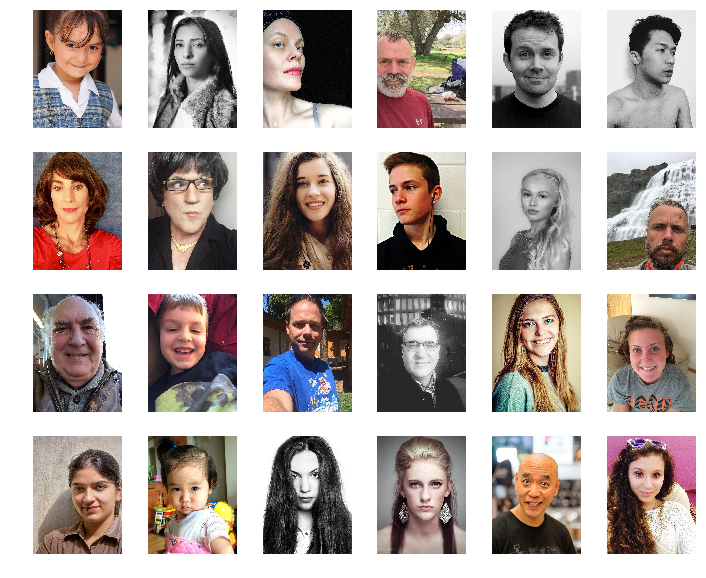

In [9]:
plot_few_potraits(img_f)

Potraits seem to occupy majority of space in the images

Our model is expecting a 3 channel image (i.e RGB). However as long as the segmentation mask is present we dont mind if image is grayscale.   
Hence the below function converts 1 channel grayscale images to 3 channel grayscale

In [10]:
######### To be executed only once ###########
def convert_to_3_channels(imgf):
    for f in imgf:
        img = Image.open(f)
        img_arr = np.array(img)
        if len(img_arr.shape) == 2:
            img = img.convert('RGB')
            img.save(f)

In [11]:
########  RUN ONLY Once ############
# convert_to_3_channels(img_f)

In [12]:
# Verifying no images are corrupted
# Displaying a few file names
verify_images(path_img,delete=False,n_channels=3)  # fastai builtin
img_f[:4]

[PosixPath('data/[EG_code_data]_release/data/images_data_crop/00001.jpg'),
 PosixPath('data/[EG_code_data]_release/data/images_data_crop/00002.jpg'),
 PosixPath('data/[EG_code_data]_release/data/images_data_crop/00003.jpg'),
 PosixPath('data/[EG_code_data]_release/data/images_data_crop/00004.jpg')]

In [13]:
# Names of a few masks
sorted(path_mask.ls())[:5]

[PosixPath('data/[EG_code_data]_release/data/images_mask/00001_mask.mat'),
 PosixPath('data/[EG_code_data]_release/data/images_mask/00002_mask.mat'),
 PosixPath('data/[EG_code_data]_release/data/images_mask/00003_mask.mat'),
 PosixPath('data/[EG_code_data]_release/data/images_mask/00004_mask.mat'),
 PosixPath('data/[EG_code_data]_release/data/images_mask/00005_mask.mat')]

In [14]:
# Total number of mask files
len(path_mask.ls())

1887


There are 1887 masks but only 1656 images present

In [15]:
# Getting the train test splits
# We name the test splits as val_list (validation set)
# Displaying the train_list as a sanity check
train_list = sio.loadmat(path/'trainlist.mat')['trainlist'].squeeze()
val_list = sio.loadmat(path/'testlist.mat')['testlist'].squeeze()
train_list

array([   1,    3,    4,    6, ..., 2629, 2630, 2631, 2632], dtype=uint16)

To get the train list to map to actual file names like '00001.jpg' some manupulation will be required    


In [16]:
len(train_list),len(val_list)

(1529, 300)

According to the numbers above there should be 1529 images in the Train set and 300 images in the validation set.  
We try to compare the numbers below

In [17]:
# Getting file names in the form of train/val_list
fnames = []
for f in img_f:
    fnames.append(int(f.name[:-4]))
fnames[:5],len(fnames)

([1, 2, 3, 4, 5], 1656)

In [18]:
train_miss = [n for n in train_list if n not in fnames]
val_miss = [n for n in val_list if n not in fnames]

len(train_miss),len(val_miss)

(197, 28)

According to the numbers above we seem to be missing 197 images in the train set and 28 in the validation set.  
However if we look below we see there are 52 images that don't belong to any set. We choose to treat these as training data  

In [19]:
no_list = [n for n in fnames if (n not in train_list and n not in val_list)]
len(no_list)

52

In [20]:
# Get the corresponding .mat mask file from the image file name
def get_mask(img):
    return path_mask/f'{img.name[:-4]}_mask.mat'

In [21]:
# Getting one such file and inspecting it
mask_arr = sio.loadmat(get_mask(img_f[2]))['mask']
mask_arr

array([[0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       ...,
       [1, 1, 1, 1, ..., 1, 1, 1, 1],
       [1, 1, 1, 1, ..., 1, 1, 1, 1],
       [1, 1, 1, 1, ..., 1, 1, 1, 1],
       [1, 1, 1, 1, ..., 1, 1, 1, 1]], dtype=uint8)

In [22]:
np.unique(mask_arr)

array([0, 1], dtype=uint8)

From the unique elements above and segmentation mask drawn a little below one can presume that  0 indicates a pixel representing background  
and 1 represents a person 

In [23]:
# Getting the shape of the mask matrix
mask_arr.shape

(800, 600)

Converting the mask to .png format so that it can be opened easily by fastai's open_mask feature

In [24]:
########## Implement only once ############
# mask = Image.fromarray(mask_arr)
# mask.save(path/'mask1.png')

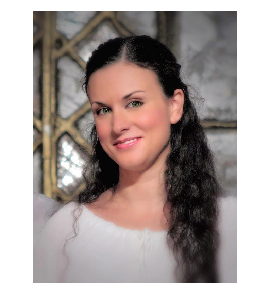

In [25]:
# Displaying the image
img = open_image(img_f[1])
img.show(figsize=(5,5))

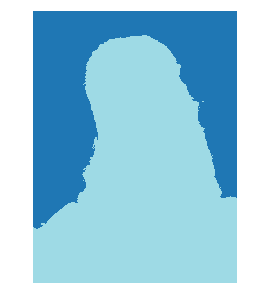

In [26]:
# Displaying the mask
mask = open_mask(path/'mask1.png')
mask.show(figsize=(5,5),alpha=1)

In [27]:
# Inspecting the shapes of the images and masks
[img.shape,mask.shape]

[torch.Size([3, 800, 600]), torch.Size([1, 800, 600])]

The image and the mask are of the same size of 800x600 also the 'mask_arr' shape above shows us the same.  
The README along with project did state that all the images are of a constant size of 800x600.  
We just did a sanity check

Next step would be to convert all the .mat maskfiles to .png to make it more suitable for the training step.  
We create a new directory 'mask_png' to store all the converted mask files

In [28]:
dir_mask = path/'mask_png'

##### Run below code only once ######
# dir_mask.mkdir(exist_ok=True)

The code below gets the image-file names maps it to the .mat mask file and converts the corresponding mask file to .png 
and stores it in the   
'mask_png' directory. We need to run this step only once

In [29]:
####### Excecute only Once ###########

def convert_mat_to_png(img_files):
    
    for f in img_files:
        mask_arr = sio.loadmat(get_mask(f))['mask']
        mask = Image.fromarray(mask_arr)
        mask.save(dir_mask/f'{get_mask(f).name[:10]}.png')

In [30]:
####### RUN only Once ###########

# convert_mat_to_png(img_f)

In [31]:
# Verifying the created png files are not corrupted. The mask files will be only 1 channel
verify_images(dir_mask,n_channels=1,delete=False)
len(dir_mask.ls())

1656

In [32]:
# Creating a map from image names to their corresponding mask.png names
get_mask_png =  lambda x: dir_mask/f'{x.name[:-4]}_mask.png'

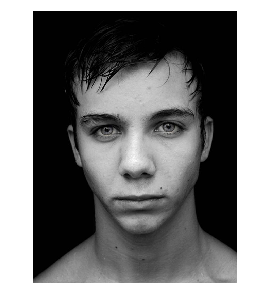

In [33]:
# Displaying an image
img2 = open_image(img_f[-3])
img2.show(figsize=(5,5))

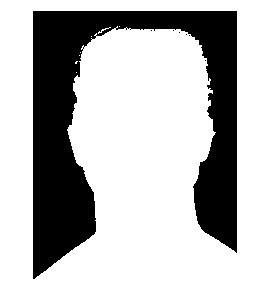

In [34]:
# Displaying the mask of the above image using a gray cmap
# Sanity checking our get_mask_png function
mask2 = open_mask(get_mask_png(img_f[-3]))
mask2.show(figsize=(5,5),alpha=1,cmap='gray')

In [35]:
# Again sanity checking the sizes 
[img2.shape,mask2.shape]

[torch.Size([3, 800, 600]), torch.Size([1, 800, 600])]

In [36]:
# Displaying the list of files to be used as validation set, to compare with results below
val_list

array([   2,    5,    8,   11, ..., 1238, 1240, 1242, 1255], dtype=uint16)

As we can see above we need a way to map the items in val_list to their actual files name.  
This is done using the function below.  
It basically strips the incoming file name of its prefixes and suffixes and gets only the integer number out,  
Checks if this integer is present in val_list and returns True if yes.  
Check examples below for futher inspection

In [38]:
def get_val_img(input):
    num = int(input.stem)
    if num in val_list:
        return True
    return False

In [39]:
[img_f[4].name,get_val_img(img_f[4])]

['00005.jpg', True]

'00005.jpg' with its suffix stripped and in integer form is basically '5' this is present in val_list (above) hence it returns True

In [40]:
[img_f[5].name,get_val_img(img_f[5])]

['00006.jpg', False]

Since 6 is not present in val_list it returns False 

In [41]:
# As inferred pixel value 0 represents background and value 1 represents person 
codes = ['background','person']

In [42]:
# Size of the images
size = np.array([800,600])

Using fastai's [datablock api](https://docs.fast.ai/data_block.html) drastically simplifies creation of a customized dataloader (what fastai call databunch)

In [43]:
src = (SegmentationItemList.from_folder(path_img)    # Where to find the data? -> in 'path_img' folder
       .split_by_valid_func(get_val_img)             # How to split in train/valid? -> use function 'get_val_img'
       .label_from_func(get_mask_png,classes=codes)) # How to get labels (in this case masks) -> 
                                                     # Use the function 'get_mask_png' where class names are 
                                                     # strored in a list 'codes' 

In [44]:
data = (src.transform(get_transforms(),size=size//2,tfm_y=True)
        .databunch(bs=6)
        .normalize(imagenet_stats))

for data augmentation we rely on defaults of 'get_transforms', some of the defaults are:   
get_transforms(do_flip:bool=True, flip_vert:bool=False, max_rotate:float=10.0, max_zoom:float=1.1, max_lighting:float=0.2, max_warp:float=0.2, p_affine:float=0.75, p_lighting:float=0.75)

we start with images of half the size i.e '(size//2)'. This is a trick I picked up at fastai MOOC, its called progressive resizing. The idea being training a model on smaller image size and then transfer learning this model on original image sizes for futher tuning helps to improve performance and  reduce overfitting 

Setting tfm_y = True makes sure that all transforms applied to images also gets applied to their corresponding masks. Finally we create a databunch of batch size 6 and normalize using imagenet_stats. The reason being that we will be using a pretrained imagenet model and performing transfer learning

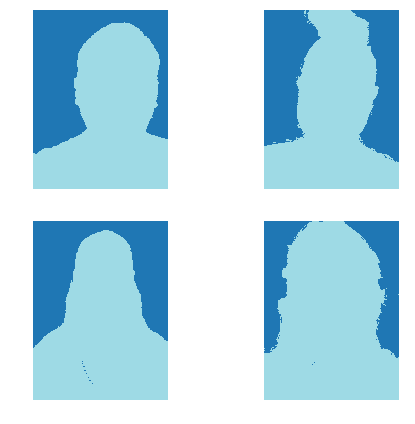

In [45]:
# Displaying a batch of masks
data.show_batch(2, figsize=(7,6),alpha=1)

In [46]:
# Sanity checking number of classes and their names
data.classes,data.c

(['background', 'person'], 2)

We now need to choose a metric for our problem. Two of which come to mind useful for segmentation tasks are pixel level classification accuracy and Intersection over Union (IoU). Since my aim in this notebook is to compare my results with the ones in the paper, it would be wise to use the same metric used in the paper -> IoU 

In [47]:
diou = partial(dice,iou=True)

According to the fastai docs for '[dice](https://docs.fast.ai/metrics.html#dice)'  
Dice coefficient metric for binary target. If iou=True, returns iou metric classic for segmentation problems.  
Hence we create a python partial with argument iou = True always

In [38]:
learn = unet_learner(data,models.resnet34,metrics= diou)

'unet_learner' creates a model with  U-Net architecture using a pretrained resnet34 block.
The reason for choosing using U-Net is partly because a lot of kaggle participants seem to prefer this for competitons that involve segmentation tasks and also I have seen U-Nets work extremely well on segmentation datasets such as CamVid

We will be performing transfer learning using a pretrained resnet34 model on imagenet
The reason for selecting resnet34 is down to results of the   
[Standford Dawn Bench](https://dawn.cs.stanford.edu/benchmark/#imagenet) Competition.  
We can see that Resnets provide a perfect balance of high accuracy and faster training time.  
We start with resnet34 as it has less parameters and is computationally less intensive than resnet50.
We can always move to a bigger model if we don't get satisfactory results 

The default loss in fastai is Cross Entropy hence we don't need to explicitly set it

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


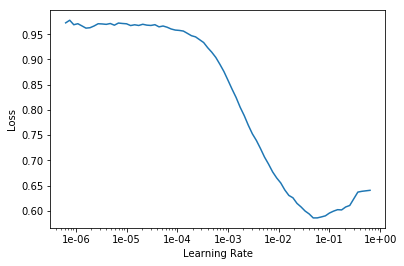

In [30]:
lr_find(learn)
learn.recorder.plot()

The code above excecutes a Learning Rate finder. We gradually increase the LR from a very small value as we feed in the first 100 minibatches for training. The logic being change in loss will be minimum untill we encounter a small range of LRs where there is a steep fall in loss (as shown in figure above). We tend to choose a LR where the fall is steepest (in this case around 2e-3). Beyond this range the loss shoots up indicating if a LR taken from this part will be too high and might cause model to diverge 

In [31]:
# Setting the learning rate
lr = 2e-3

In [32]:
learn.fit_one_cycle(7, slice(lr))

epoch,train_loss,valid_loss,dice
1,0.157275,0.118756,0.937457
2,0.130605,0.114038,0.950393
3,0.103609,0.089525,0.949715
4,0.093399,0.102559,0.949383
5,0.083925,0.063062,0.967176
6,0.068697,0.057303,0.968660
7,0.062581,0.058352,0.968712


The fit one cycle allows us to train networks faster with better precision.  
This [blog post](https://sgugger.github.io/the-1cycle-policy.html) explores the idea and delves deeper into explaining it

In [33]:
learn.save('stage-1-half-size')

In [37]:
learn.load('stage-1-half-size');

Untill now we have been training only the final layers that were added to the model, 
the initial resnet blocks were frozen.  
Now we unfreeze the entire model and train it using something called 
discrimiative learning rates i.e (training different layers with differnt LRs).  
The intuition being that the earlier layers of a model are already near their optimum but their performance for a particular task can still improve by fine tuning them using small LRs. Hence as move higher up the model we gradually increase the LR.

In [38]:
# Unfreezing all layers
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


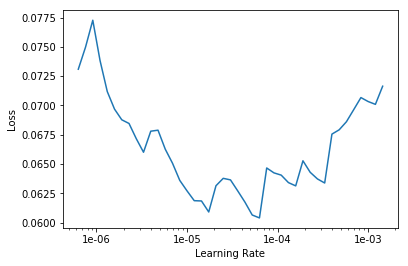

In [39]:
# Repeating LR find 
lr_find(learn)
learn.recorder.plot(skip_end=15)

Sharpest fall at around 4e-6. We set this as LR for the initial layers. The final layers can probably still be trained at higher LR, as such we set it at   
lr/5 -> (2e-3/5). The layers in between get LRs in between these two limits

In [40]:
# Setting the LRs
lrs = slice(4e-6,lr/5)

In [41]:
learn.fit_one_cycle(7,lrs)

epoch,train_loss,valid_loss,dice
1,0.063035,0.060772,0.967619
2,0.068130,0.063903,0.965588
3,0.063081,0.057714,0.968809
4,0.056447,0.054514,0.970848
5,0.049408,0.055457,0.969795
6,0.045342,0.053842,0.971648
7,0.045470,0.051808,0.972216


Wow using U-nets with images resized to half its size the model has been able to perform exceptionally well.  
Hopefully this will translate using the original size 

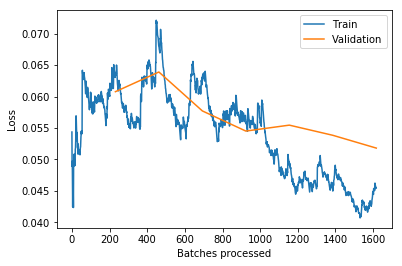

In [42]:
# Plotting the train and validation losses
learn.recorder.plot_losses()

In [43]:
learn.save('stage-2-half-size')

In [44]:
learn.load('stage-2-half-size');

Now we are ready to go big and try the approch on original resolution of images (800x600).  
We reduce the batch size(bs)

In [48]:
data = (src.transform(get_transforms(),size=size,tfm_y=True)
        .databunch(bs=4)
        .normalize(imagenet_stats))

In [49]:
learn = unet_learner(data,models.resnet34,metrics= diou).to_fp16()

Since this was running on a VM with only 8GB of Tesla P4, I was getting CUDA out of memory even with a batch size of 4 so I had to resort to using mixed precision training. Hence the 'to_fp16' above 

Loading the model trained on half resoution images and trying to train it on this original dataset

In [65]:
learn.load('stage-2-half-size');

In [30]:
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


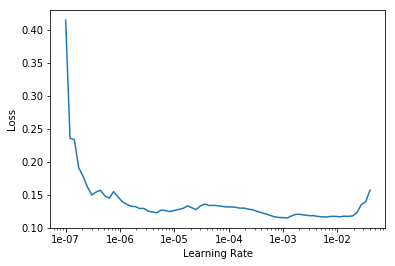

In [40]:
learn.recorder.plot(skip_start=0,skip_end=20)

There is no sharpest fall in this case, so we tend to find the lowest point before a increase in loss (around 1e-3) and take a LR 10x less than this

In [67]:
lr = 1e-4

Training using the same principles

In [42]:
learn.fit_one_cycle(7, slice(lr))

epoch,train_loss,valid_loss,dice
1,0.118095,0.094952,0.948230
2,0.103101,0.076212,0.958415
3,0.096308,0.074210,0.959339
4,0.084031,0.072642,0.960919
5,0.082261,0.068975,0.962549
6,0.071801,0.067952,0.962574
7,0.074978,0.068087,0.962338


In [43]:
learn.save('stage-1-full-size')

In [66]:
learn.load('stage-1-full-size');

In [67]:
# Unfreezing and training
learn.unfreeze()

In [59]:
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


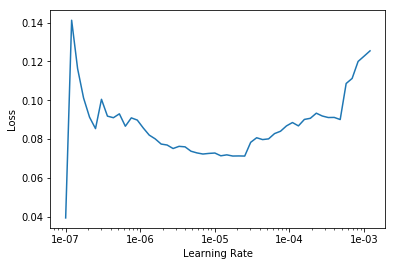

In [60]:
learn.recorder.plot(skip_start=0,skip_end=5)

In [68]:
lrs = slice(3e-6,lr/5)

In [69]:
learn.fit_one_cycle(10,lrs)

epoch,train_loss,valid_loss,dice
1,0.068505,0.066465,0.963371
2,0.075013,0.065837,0.963739
3,0.070322,0.063575,0.965206
4,0.067397,0.062693,0.965868
5,0.059891,0.060816,0.966743
6,0.062753,0.061535,0.966280
7,0.055968,0.061492,0.966587
8,0.052939,0.060416,0.966980
9,0.057188,0.060428,0.967394
10,0.052796,0.061117,0.966992


In [70]:
learn.save('stage-2-full-size')

In [59]:
learn.load('stage-2-full-size');

The model seem to saturate around 0.967 (~=96.7%). What I do next is take this model and try training it for smaller and smaller LRs using one cycle policy for few epochs in the hope that it improves.

I frequently run into CUDA out of memory hence need to restart, load , unfreeze and train again

In [60]:
learn.unfreeze()

In [48]:
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


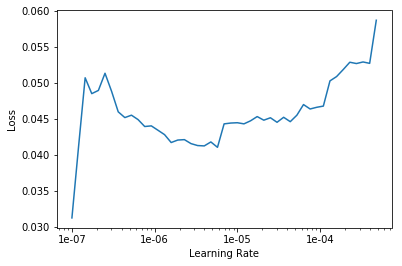

In [51]:
learn.recorder.plot(skip_start=0,skip_end=10)

In [61]:
lrs = slice(1e-6,lr/10)

A smaller slice as compared to the one above

In [62]:
learn.fit_one_cycle(5,lrs)

epoch,train_loss,valid_loss,dice
1,0.054469,0.060990,0.966734
2,0.054448,0.060316,0.967024
3,0.050385,0.060887,0.967110
4,0.050208,0.060078,0.967561
5,0.049797,0.059739,0.967484


We see an improvement in the forth decimal place

In [63]:
learn.save('stage-2-full-size-final')

In [62]:
learn.load('stage-2-full-size-final');

Repeating the process one more time

In [63]:
learn.unfreeze()

In [64]:
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


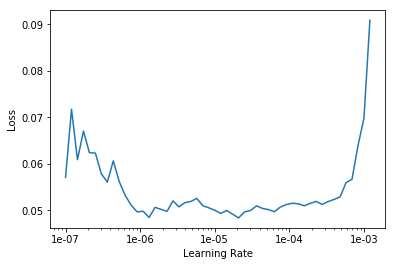

In [65]:
learn.recorder.plot(skip_start=0,skip_end=10)

In [68]:
lrs = slice(5e-7,lr/15)

More smaller slice

In [69]:
learn.fit_one_cycle(5,lrs)

epoch,train_loss,valid_loss,dice
1,0.050263,0.059538,0.967857
2,0.051029,0.060456,0.967406
3,0.051654,0.060309,0.967439
4,0.052371,0.059585,0.967756
5,0.047563,0.059363,0.968000


Although time consuming, we see an improvement 

Wow   
We are able to finally reach an IoU of 96.8%. This is almost 0.9% greater than the results achieved in the paper (95.91%) and without the additional inputs or preprocessing it uses and lesser data   

In [70]:
learn.save('full-size-final')

In [50]:
learn.load('full-size-final');

We need to convert model back to full precision

In [51]:
learn.model.float();

Next steps will be to visualize our results and actually see how are model has performed.  
The code below gets the predictions from the validation set

In [52]:
preds,targets = learn.get_preds(ds_type=DatasetType.Valid)
preds.shape,targets.shape

(torch.Size([272, 2, 800, 600]), torch.Size([272, 1, 800, 600]))

The difference of size in the 1st dimension is due to a different prediction for the 0th class and 1st class.  
Hence we run argmax in this dimension

In [53]:
preds = preds.argmax(dim=1)

In [54]:
# Utility function for plotting the val set
def plot_image(img,i,rows,cols,fig):
    img = image2np(img)
    fig.add_subplot(rows,cols,i+1)
    plt.imshow(img)
    plt.axis('off')
    return i+1

In [55]:
# Utility function for plotting the val set
def plot_mask(mask,i,rows,cols,fig):
    fig.add_subplot(rows,cols,i+1)
    plt.imshow(mask.squeeze(),cmap='gray')
    plt.axis('off')
    return i+1

In [56]:
# Function for plotting the val set
def faces(ds_valid,preds,targs,rows):
    preds = preds.numpy(); targs = targs.numpy()
    pos = np.random.choice(range(targs.shape[0]),rows,replace=False)
    #preds = preds[pos]; targs = targs[pos]
    i = 0;cols=4
    fig = plt.figure(figsize=(4*cols,4*rows))
    args = (rows,cols,fig)
    tab = '\t'*4
    plt.title(f"Image {tab} Ground Truth {tab} Prediction {tab} Cutoff"
              .expandtabs(),fontsize=17)
    plt.axis('off')
    for idx in pos:
        img = ds_valid[idx]
        i = plot_image(img.data,i,*args)
        mask = targs[idx]
        i = plot_mask(mask,i,*args)
        mask2 = preds[idx]
        i = plot_mask(mask2,i,*args)
        final = img.data * tensor(mask2).float()
        i = plot_image(final,i,*args)

We can visualize the results by plotting the ground truth mask and prediction generated by the model.  
An even better way would be display a cutoff of the original potrait using the prediction mask.  
Hence the plots below.   
Each row contains an image randomly selected along with its corresponding ground truth and prediction masks and the cutoff it created

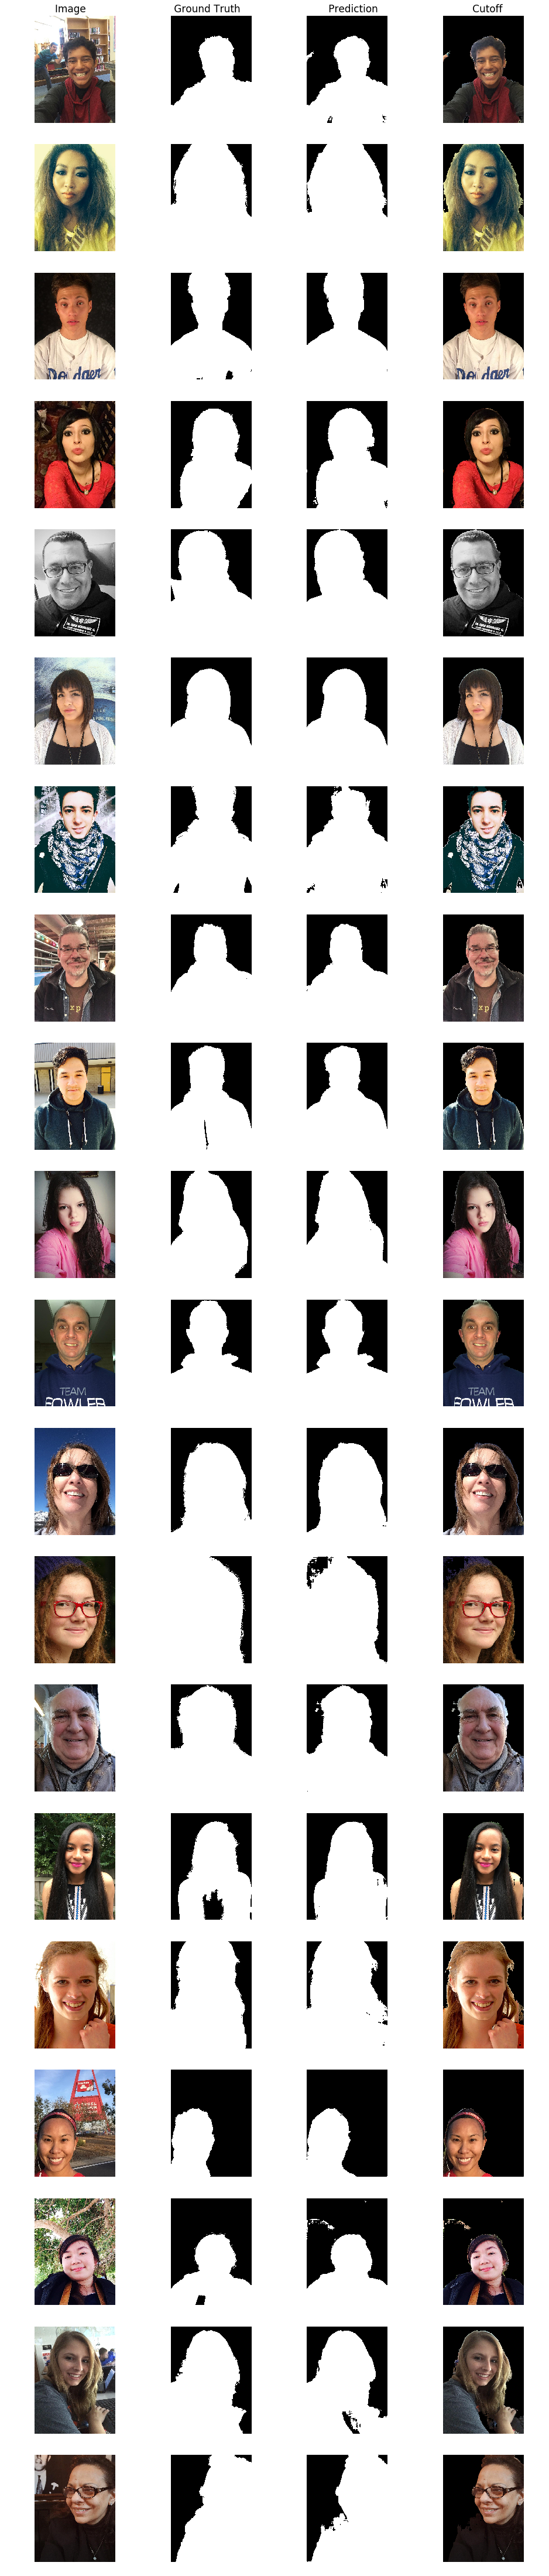

In [57]:
faces(data.valid_ds.x,preds,targets,20)

We see that the results are amzaing both in terms of quantitative accuracy (IoU) as well as visual comparision.
This vindicates the use of U-Nets for the task of automatic potrait segmentation

Some obseravtion when running the code to plot the results a few times.  
* The model seems to suffer when there is very low contrast between foreground and background  
  
* This also happens when there is a sudden patch of brightness (due to some source of light) on the potrait  

Even when the above points are applicable in an image, the mask generated are somewhat acceptable. Maybe having more examples of such cases can help us improve the performance
* Works well for grayscale images

The next notebook deals how to use this model to generate masks for CelebA dataset